In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()
import seaborn as sns
from scipy.stats import pearsonr

from zipfile import ZipFile
import scipy as sp
import re


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap


from scipy.special import binom

In [9]:
log_file_path = "../mascot_glm/results/main/combined_exp_glm.log"


In [10]:
burnin_percent = 0.2

In [11]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                #print(line)
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "Ne." in col:
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "Ne.region.1" where region is deme and 1 is interval 1
                        interval = name.split(".")[2]
                       
                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [12]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [13]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[2]
            next_interval = int(interval)+1
            local_series = input_df[i].astype('float').to_numpy()
            mean_log = local_series.mean()
            median_log = np.median(local_series)
            mean_linear = math.log(median_log)
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = math.log(lower_hpd_log_95)
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = math.log(upper_hpd_log_95)
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = math.log(lower_hpd_log_50)
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = math.log(upper_hpd_log_50)
            
            try:
                next_local_series = input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float').to_numpy()
                diff_series = np.subtract(local_series, next_local_series)
                diff_mean_log = diff_series.mean()
                diff_median_log = np.median(diff_series)
                diff_hpd_95 = az.hdi(diff_series, 0.95)
                diff_lower_hpd_log_95 = diff_hpd_95[0]
                diff_lower_hpd_linear_95 = math.exp(diff_lower_hpd_log_95)
                diff_upper_hpd_log_95 = diff_hpd_95[1]
                diff_upper_hpd_linear_95 = math.exp(diff_upper_hpd_log_95)
                diff_hpd_50 = az.hdi(diff_series, 0.50)
                diff_lower_hpd_log_50 = diff_hpd_50[0]
                diff_lower_hpd_linear_50 = math.exp(diff_lower_hpd_log_50)
                diff_upper_hpd_log_50 = diff_hpd_50[1]
                diff_upper_hpd_linear_50 = math.exp(diff_upper_hpd_log_50)
            except KeyError:
                pass   
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "median_Ne_log" : median_log, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear_95":upper_hpd_linear_95,"lower_hpd_linear_95":lower_hpd_linear_95,
                                                   "upper_hpd_linear_50": upper_hpd_linear_50, "lower_hpd_linear_50": lower_hpd_linear_50,
                                                   "diff_mean_Ne_log":diff_mean_log, "diff_mean_log":diff_mean_log,
                                                   "diff_upper_hpd_log_95":diff_upper_hpd_log_95,"diff_lower_hpd_log_95":diff_lower_hpd_log_95, 
                                                   "diff_upper_hpd_log_50":diff_upper_hpd_log_50,"diff_lower_hpd_log_50":diff_lower_hpd_log_50,
                                                   "diff_upper_hpd_linear":diff_upper_hpd_linear_95,"diff_lower_hpd_linear":diff_lower_hpd_linear_95,
                                                   "diff_upper_hpd_linear_50":diff_upper_hpd_linear_50,"diff_lower_hpd_linear_50":diff_lower_hpd_linear_50})
                new_df = new_df.append(local_df)
                #print(new_df)
            except:
                pass
            
    return(new_df)

In [14]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
Ne_df

28124


,sample,Ne.CentralEurope.0,Ne.CentralEurope.1,Ne.CentralEurope.2,Ne.CentralEurope.3,Ne.CentralEurope.4,Ne.CentralEurope.5,Ne.CentralEurope.6,Ne.CentralEurope.7,Ne.CentralEurope.8,...,Ne.WesternEurope.34,Ne.WesternEurope.35,Ne.WesternEurope.36,Ne.WesternEurope.37,Ne.WesternEurope.38,Ne.WesternEurope.39,Ne.WesternEurope.40,Ne.WesternEurope.41,Ne.WesternEurope.42,Ne.WesternEurope.43
0,0,2.504762812674862E-4,3.4614663776075537E-4,4.703974917675134E-4,6.617902405458704E-4,9.016774255942793E-4,0.029227809631891668,0.039752227200038015,0.05395512721372307,0.07211725059277527,...,0.7642639068858176,0.08972832009320399,0.08972832009320399,0.08972832009320399,0.08972832009320399,0.08972832009320399,0.08972832009320399,0.08972832009320399,0.08972832009320399,0.08972832009320399
1,5000,0.0023574544593308547,0.0032578930453699712,0.004427328044850383,0.006228694971921962,0.008486486054043505,0.015167587802368456,0.020629168042013566,0.027999673588579407,0.03742479317498318,...,0.7597978677220529,0.08920398525542797,0.08920398525542797,0.08920398525542797,0.08920398525542797,0.08920398525542797,0.08920398525542797,0.08920398525542797,0.08920398525542797,0.08920398525542797
2,10000,0.005483710598560662,0.007244813242465734,0.00943419799414603,0.012657266689050754,0.016519126346739806,0.06343024946312711,0.0826579084772228,0.10752335308274735,0.13803313829875283,...,0.8363466549122088,0.09641931612496726,0.09641931612496726,0.09641931612496726,0.09641931612496726,0.09641931612496726,0.09641931612496726,0.09641931612496726,0.09641931612496726,0.09641931612496726
3,15000,0.0014162277329817154,0.0019571612353652137,0.002659692845945601,0.003741854068317186,0.0050982095784409855,0.01390862912410427,0.0189168805991937,0.02567561042756693,0.03431841470770111,...,0.5959587404001375,0.09762004111449743,0.09762004111449743,0.09762004111449743,0.09762004111449743,0.09762004111449743,0.09762004111449743,0.09762004111449743,0.09762004111449743,0.09762004111449743
4,20000,3.135854096959911E-4,4.5744053985219933E-4,6.543444666597554E-4,9.74640782714134E-4,0.0013983971840791907,0.002020710186343494,0.00289331928613931,0.004132808846689916,0.005798495858442902,...,0.42639886640466473,0.07872101130924808,0.07872101130924808,0.07872101130924808,0.07872101130924808,0.07872101130924808,0.07872101130924808,0.07872101130924808,0.07872101130924808,0.07872101130924808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28119,140595000,0.003292611207550264,0.004391534139222483,0.005770365131054429,0.007819683474598547,0.010298609762564316,0.017643716305120353,0.02320052821990675,0.030451580568532213,0.03942651452590648,...,0.7073926540423983,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147
28120,140600000,0.0010018342842830076,0.0013706304010637194,0.0018449426070125186,0.0025681938691472683,0.0034656224547089482,0.017774870467125867,0.02394517722460166,0.03219315388480236,0.04264336247721768,...,0.5617846806840007,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374
28121,140605000,0.001321059162915087,0.0018073686224374694,0.00243281586015061,0.003386524194874665,0.004569909785303587,0.02102400118716855,0.028322199890460774,0.038077853042280146,0.05043829180100065,...,0.6851209389283835,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386
28122,140610000,7.86972341544367E-4,0.0010766732912209894,0.0014492604477942372,0.002017397063017435,0.0027223554442868227,0.009589688362034603,0.01291861945111257,0.017368470488561456,0.023006443710637123,...,0.67784730707066,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.0635625765

In [15]:
ne_summary = generate_summary_df(Ne_df)
ne_summary

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/533036872.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear_95,...,diff_mean_Ne_log,diff_mean_log,diff_upper_hpd_log_95,diff_lower_hpd_log_95,diff_upper_hpd_log_50,diff_lower_hpd_log_50,diff_upper_hpd_linear,diff_lower_hpd_linear,diff_upper_hpd_linear_50,diff_lower_hpd_linear_50
0,CentralEurope,0,0.004966,-6.230240,0.001969,0.017548,0.000012,0.001982,0.000037,-4.042789,...,-0.001527,-0.001527,-0.000008,-0.005113,-0.000031,-0.000726,0.999992,0.994900,0.999969,0.999274
0,CentralEurope,1,0.006492,-5.920831,0.002683,0.022655,0.000018,0.002734,0.000092,-3.787387,...,-0.001894,-0.001894,-0.000010,-0.006288,-0.000064,-0.000950,0.999990,0.993732,0.999936,0.999050
0,CentralEurope,2,0.008386,-5.627491,0.003598,0.028882,0.000028,0.003656,0.000122,-3.544530,...,-0.002788,-0.002788,-0.000021,-0.009172,-0.000099,-0.001443,0.999979,0.990870,0.999901,0.998558
0,CentralEurope,3,0.011174,-5.296647,0.005008,0.038033,0.000029,0.005095,0.000210,-3.269289,...,-0.003346,-0.003346,-0.000030,-0.010932,-0.000145,-0.001798,0.999970,0.989127,0.999855,0.998203
0,CentralEurope,4,0.014520,-4.998704,0.006747,0.048597,0.000085,0.006828,0.000295,-3.024188,...,-0.010835,-0.010835,0.049510,-0.091245,0.001896,-0.009987,1.050756,0.912794,1.001898,0.990062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,WesternEurope,39,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
0,WesternEurope,40,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
0,WesternEurope,41,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
0,WesternEurope,42,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
test = ne_summary
test['days'] = (test.interval.astype(int)) *7 
test['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - test.days.map(timedelta)
test.deme[test.deme == "CentralEurope"] = "Central Europe"
test.deme[test.deme == "NorthAmerica"] = "North America"
test.deme[test.deme == "SouthAmerica"] = "South America"
test.deme[test.deme == "SouthernEurope"] = "Southern Europe"
test.deme[test.deme == "WesternEurope"] = "Western Europe"
#test.date = test.date.astype(str)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/807276509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.deme[test.deme == "CentralEurope"] = "Central Europe"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/807276509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.deme[test.deme == "NorthAmerica"] = "North America"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/807276509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [17]:
test

,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,upper_hpd_linear_95,...,diff_upper_hpd_log_95,diff_lower_hpd_log_95,diff_upper_hpd_log_50,diff_lower_hpd_log_50,diff_upper_hpd_linear,diff_lower_hpd_linear,diff_upper_hpd_linear_50,diff_lower_hpd_linear_50,days,date
0,Central Europe,0,0.004966,-6.230240,0.001969,0.017548,0.000012,0.001982,0.000037,-4.042789,...,-0.000008,-0.005113,-0.000031,-0.000726,0.999992,0.994900,0.999969,0.999274,0,2023-01-03
0,Central Europe,1,0.006492,-5.920831,0.002683,0.022655,0.000018,0.002734,0.000092,-3.787387,...,-0.000010,-0.006288,-0.000064,-0.000950,0.999990,0.993732,0.999936,0.999050,7,2022-12-27
0,Central Europe,2,0.008386,-5.627491,0.003598,0.028882,0.000028,0.003656,0.000122,-3.544530,...,-0.000021,-0.009172,-0.000099,-0.001443,0.999979,0.990870,0.999901,0.998558,14,2022-12-20
0,Central Europe,3,0.011174,-5.296647,0.005008,0.038033,0.000029,0.005095,0.000210,-3.269289,...,-0.000030,-0.010932,-0.000145,-0.001798,0.999970,0.989127,0.999855,0.998203,21,2022-12-13
0,Central Europe,4,0.014520,-4.998704,0.006747,0.048597,0.000085,0.006828,0.000295,-3.024188,...,0.049510,-0.091245,0.001896,-0.009987,1.050756,0.912794,1.001898,0.990062,28,2022-12-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Western Europe,39,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,273,2022-04-05
0,Western Europe,40,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,280,2022-03-29
0,Western Europe,41,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,287,2022-03-22
0,Western Europe,42,0.082377,-2.538774,0.078963,0.131204,0.038303,0.089964,0.060400,-2.031000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,294,2022-03-15


In [18]:
domain = ['Central Europe', 'North America', 'South America' ,"Southern Europe", "Western Europe"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]
,  scale=alt.Scale(domain=domain, range=range_)

('scale=alt.Scale(domain=domain,', 'range=range_)')

In [19]:
test = test.reset_index()

In [20]:
#smooth out estimates by using a three week rolling average
rolling_final_ne =test.groupby(["deme"])[ "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50", "upper_hpd_linear_95","lower_hpd_linear_95", "upper_hpd_linear_50", "lower_hpd_linear_50", "mean_Ne_linear" ].rolling(3, min_periods =1).mean().reset_index()
test_new = pd.merge(rolling_final_ne, test, left_on = "level_1",right_index = True, how = "right")

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/2270857039.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_final_ne =test.groupby(["deme"])[ "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50", "upper_hpd_linear_95","lower_hpd_linear_95", "upper_hpd_linear_50", "lower_hpd_linear_50", "mean_Ne_linear" ].rolling(3, min_periods =1).mean().reset_index()


In [21]:
test_new

,deme_x,level_1,upper_hpd_log_95_x,lower_hpd_log_95_x,upper_hpd_log_50_x,lower_hpd_log_50_x,upper_hpd_linear_95_x,lower_hpd_linear_95_x,upper_hpd_linear_50_x,lower_hpd_linear_50_x,...,diff_upper_hpd_log_95,diff_lower_hpd_log_95,diff_upper_hpd_log_50,diff_lower_hpd_log_50,diff_upper_hpd_linear,diff_lower_hpd_linear,diff_upper_hpd_linear_50,diff_lower_hpd_linear_50,days,date
0,Central Europe,0,0.017548,0.000012,0.001982,0.000037,-4.042789,-11.365232,-6.223829,-10.202406,...,-0.000008,-0.005113,-0.000031,-0.000726,0.999992,0.994900,0.999969,0.999274,0,2023-01-03
1,Central Europe,1,0.020102,0.000015,0.002358,0.000064,-3.915088,-11.138399,-6.062825,-9.750198,...,-0.000010,-0.006288,-0.000064,-0.000950,0.999990,0.993732,0.999936,0.999050,7,2022-12-27
2,Central Europe,2,0.023028,0.000019,0.002791,0.000083,-3.791568,-10.919411,-5.912377,-9.504633,...,-0.000021,-0.009172,-0.000099,-0.001443,0.999979,0.990870,0.999901,0.998558,14,2022-12-20
3,Central Europe,3,0.029857,0.000025,0.003828,0.000141,-3.533735,-10.614188,-5.597630,-8.926035,...,-0.000030,-0.010932,-0.000145,-0.001798,0.999970,0.989127,0.999855,0.998203,21,2022-12-13
4,Central Europe,4,0.038504,0.000047,0.005193,0.000209,-3.279336,-10.100197,-5.292607,-8.535749,...,0.049510,-0.091245,0.001896,-0.009987,1.050756,0.912794,1.001898,0.990062,28,2022-12-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Western Europe,215,0.131204,0.038303,0.089964,0.060400,-2.031000,-3.262234,-2.408342,-2.806772,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,273,2022-04-05
216,Western Europe,216,0.131204,0.038303,0.089964,0.060400,-2.031000,-3.262234,-2.408342,-2.806772,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,280,2022-03-29
217,Western Europe,217,0.131204,0.038303,0.089964,0.060400,-2.031000,-3.262234,-2.408342,-2.806772,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,287,2022-03-22
218,Western Europe,218,0.131204,0.038303,0.089964,0.060400,-2.031000,-3.262234,-2.408342,-2.806772,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,294,2022-03-15


In [22]:
line = alt.Chart(test_new).mark_area(interpolate='monotone').encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False, format="%B %Y",tickCount = "month")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Ne \u03c4 (years)", grid=False)),#,scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_50_x' ),
    color=alt.Color('deme_x:N',  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=400
).transform_filter(
    (datum.upper_hpd_log_50_x < 30)
)

band = alt.Chart(test_new).mark_area(
    opacity=0.3, interpolate='monotone'
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x'),#axis=None),#, scale=alt.Scale(domain=(0, 13))),
    alt.Y2('upper_hpd_log_95_x'),
    color=alt.Color('deme_x:N', title = "Region", legend=alt.Legend(title= "Region",orient = "left", offset = -340, symbolSize = 150, labelFontSize = 25, labelLimit= 0, titleFontSize = 25))
).properties(
    width=800,
    height=400
 ).transform_filter(
     (datum.upper_hpd_log_95_x < 30)
 )

ne_plot = line + band
(ne_plot).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)



alt.LayerChart(...)

## now testing the correlation between case counts and Ne

In [23]:
region = {'Canada':'North America',
          'United States':'North America',
         'Finland':'Northern Europe',
           'Austria': 'Western Europe',
        'Germany':'Western Europe', 
        'Switzerland':'Western Europe',
         'United Kingdom':'Western Europe',
        'France':'Western Europe',
        'Belgium':'Western Europe',
        'Netherlands':'Western Europe',
        'Slovakia':'Central Europe',
        'Slovenia':'Central Europe',
        'Italy':'Southern Europe',
        'Portugal':'Southern Europe',
        'Spain':'Southern Europe',
         'Colombia':'South America',
          
        'Peru':'South America'}

In [24]:
raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
raw_cases["region"] = np.nan
raw_cases.region = raw_cases.location.map(region)
raw_cases = raw_cases.dropna()
raw_cases.date = raw_cases.date.astype('datetime64[ns]')
#weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
#weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )

combined_df = pd.merge(test, raw_cases,  how='left', left_on=['deme','date'], right_on = ['region','date'])
combined_df = combined_df[combined_df.cases >0]
combined_df["log_cases"] = np.log(combined_df.cases)

/Users/mparedes/opt/miniconda3/envs/nextstrain/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


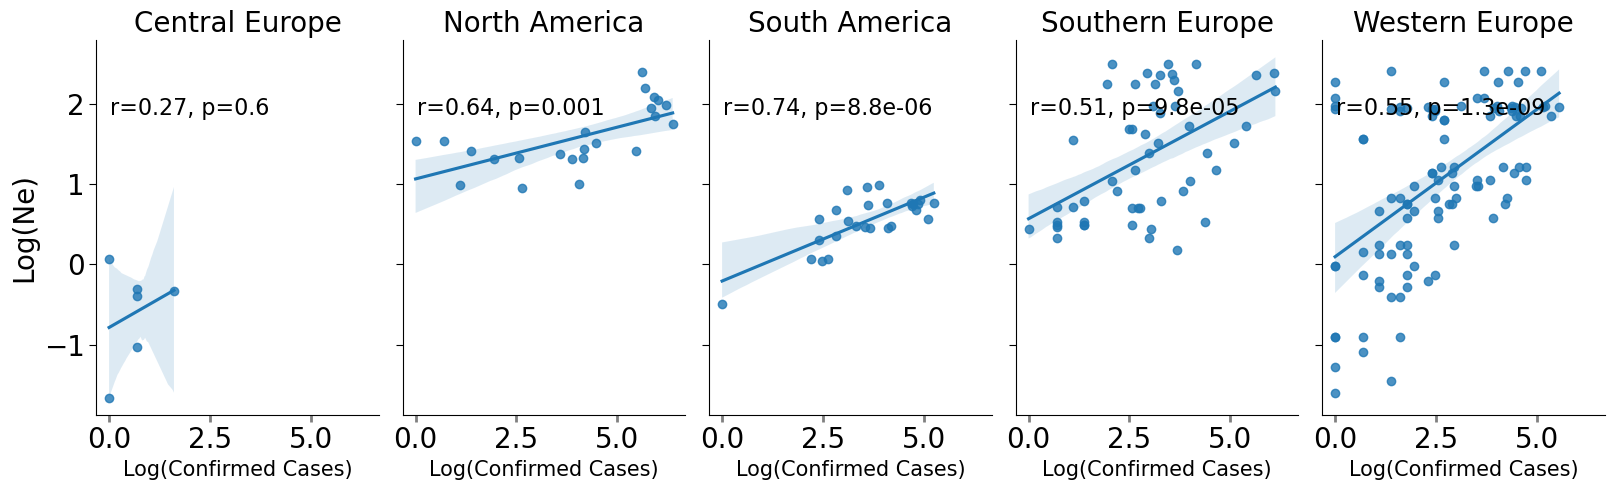

In [25]:
#correlation between Ne and cases
g = sns.lmplot(x="log_cases", y="mean_Ne_linear", data=combined_df,
               col='region', height=5, aspect=0.65)
g.set_titles(col_template="{col_name}", size = 20)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_cases'], data['mean_Ne_linear'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, size = 16)
    ax.tick_params(axis='y',labelsize=20,size=5)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_ylabel("Log(Ne)" , size=20)
    ax.set_xlabel("Log(Confirmed Cases)" , size=15)
    
g.map_dataframe(annotate)

plt.savefig('../figures/ne_case_correlation.png',dpi=300,bbox_inches='tight')

plt.show()

/Users/mparedes/opt/miniconda3/envs/nextstrain/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


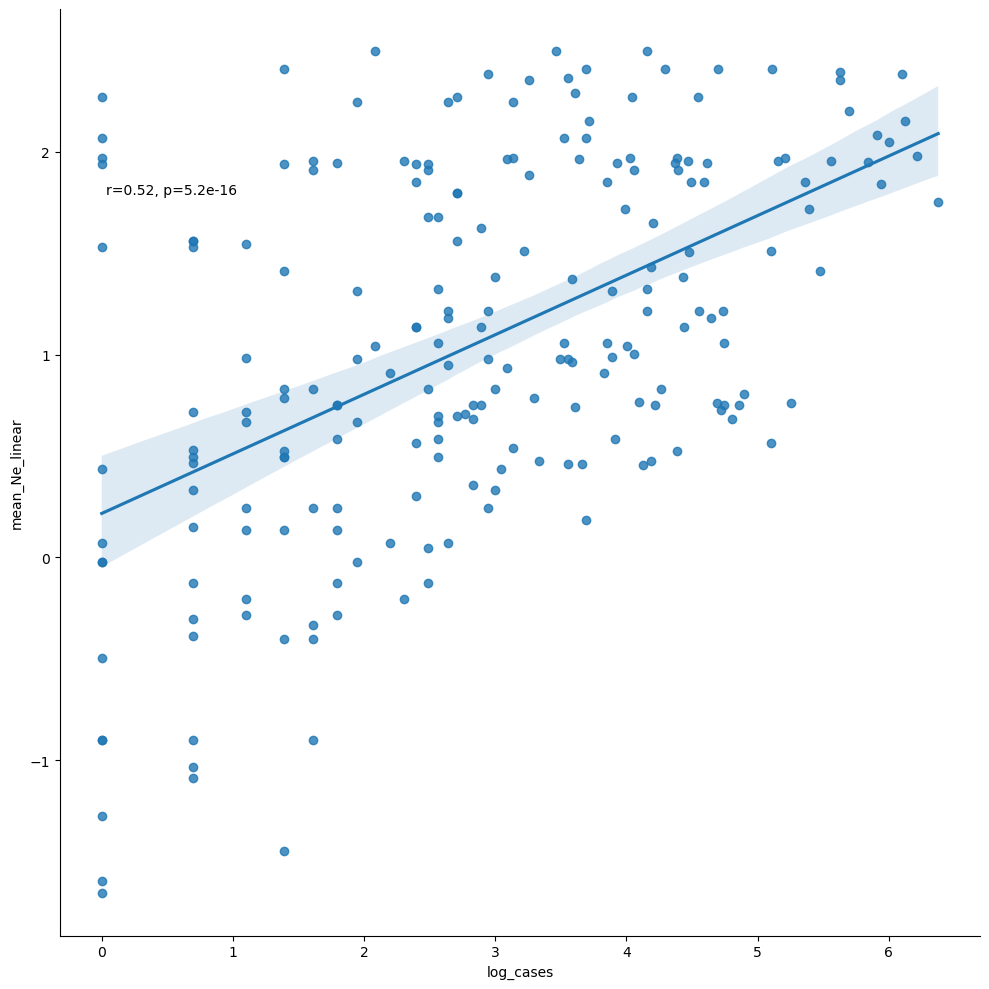

In [26]:
g = sns.lmplot(x="log_cases", y="mean_Ne_linear", data=combined_df,
                height=10, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_cases'], data['mean_Ne_linear'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

In [27]:
#now testing the correlation between Ne and prevalence
case_prevalence = pd.read_csv("../case-rt-analysis/estimates/case-prevalence-estimates_region.tsv", sep="\t", parse_dates= ["date"])
case_prevalence
case_prevalence["log_median"] = np.log(case_prevalence.median_prev)
case_prevalence["log_upper_95"] = np.log(case_prevalence.prev_upper_95)
case_prevalence["log_lower_95"] = np.log(case_prevalence.prev_lower_95)
case_prevalence

,date,region,median_prev,prev_upper_95,prev_lower_95,log_median,log_upper_95,log_lower_95
0,2022-05-07,Western Europe,7.685365,12.877002,4.940296e+00,2.039318,2.555443,1.597425
1,2022-05-08,Western Europe,9.216010,14.083878,6.343246e+00,2.220942,2.645031,1.847391
2,2022-05-09,Western Europe,10.836695,15.469023,7.705113e+00,2.382938,2.738840,2.041884
3,2022-05-10,Western Europe,12.488087,17.416237,9.063359e+00,2.524775,2.857403,2.204240
4,2022-05-11,Western Europe,14.187191,19.440145,1.040488e+01,2.652340,2.967340,2.342275
...,...,...,...,...,...,...,...,...
1241,2023-01-22,Central Europe,0.000359,137.167250,4.011274e-08,-7.931594,4.921201,-17.031572
1242,2023-01-23,Central Europe,0.000330,142.873960,3.393355e-08,-8.015725,4.961963,-17.198862
1243,2023-01-24,Central Europe,0.000309,146.670750,2.867527e-08,-8.083575,4.988190,-17.367231
1244,2023-01-25,Central Europe,0.000298,152.620850,2.420530e-08,-8.119395,5.027957,-17.536694


In [28]:
#plotting prevalence 

band3 = alt.Chart(case_prevalence).mark_area(interpolate='monotone', opacity = 0.3 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y",tickCount = "month")),
    alt.Y('prev_lower_95',axis=alt.Axis(title="Estimated Prevalence (# of cases)", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('prev_upper_95' ),
    alt.Color("region:N",legend=alt.Legend(title= "Region",offset = -170, symbolSize = 150, labelFontSize = 20, titleFontSize = 20),  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=850,
    height=300)

line3 = alt.Chart(case_prevalence).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('median_prev', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))), 
    alt.Color("region:N",  scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=800,
    height=400)

case_prev_plot = band3 + line3
case_prev_plot

alt.LayerChart(...)

In [29]:
combined_ne_prev_df = pd.merge(test, case_prevalence,  how='left', left_on=['deme','date'], right_on = ['region','date'])
combined_ne_prev_df = combined_ne_prev_df.dropna()
combined_ne_prev_df.deme[combined_ne_prev_df.deme == "CentralEurope"] = "Central Europe"
combined_ne_prev_df.deme[combined_ne_prev_df.deme == "NorthAmerica"] = "North America"
combined_ne_prev_df.deme[combined_ne_prev_df.deme == "SouthAmerica"] = "South America"
combined_ne_prev_df.deme[combined_ne_prev_df.deme == "SouthernEurope"] = "Southern Europe"
combined_ne_prev_df.deme[combined_ne_prev_df.deme == "WesternEurope"] = "Western Europe"
combined_ne_prev_df.region[combined_ne_prev_df.region == "CentralEurope"] = "Central Europe"
combined_ne_prev_df.region[combined_ne_prev_df.region == "NorthAmerica"] = "North America "
combined_ne_prev_df.region[combined_ne_prev_df.region == "SouthAmerica"] = "South America"
combined_ne_prev_df.region[combined_ne_prev_df.region == "SouthernEurope"] = "Southern Europe"
combined_ne_prev_df.region[combined_ne_prev_df.region == "WesternEurope"] = "Western Europe"



combined_ne_prev_df


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/2475725850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_ne_prev_df.deme[combined_ne_prev_df.deme == "NorthAmerica"] = "North America"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/2475725850.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_ne_prev_df.deme[combined_ne_prev_df.deme == "SouthAmerica"] = "South America"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/2475725850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

,index,deme,interval,mean_Ne_log,mean_Ne_linear,median_Ne_log,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,...,diff_lower_hpd_linear_50,days,date,region,median_prev,prev_upper_95,prev_lower_95,log_median,log_upper_95,log_lower_95
0,0,Central Europe,0,0.004966,-6.230240,0.001969,0.017548,0.000012,0.001982,0.000037,...,0.999274,0,2023-01-03,Central Europe,0.001594,64.161880,8.789955e-07,-6.441254,4.161409,-13.944486
1,0,Central Europe,1,0.006492,-5.920831,0.002683,0.022655,0.000018,0.002734,0.000092,...,0.999050,7,2022-12-27,Central Europe,0.002871,46.396294,2.231327e-06,-5.852994,3.837220,-13.012914
2,0,Central Europe,2,0.008386,-5.627491,0.003598,0.028882,0.000028,0.003656,0.000122,...,0.998558,14,2022-12-20,Central Europe,0.004238,30.659798,6.016604e-06,-5.463629,3.422952,-12.020988
3,0,Central Europe,3,0.011174,-5.296647,0.005008,0.038033,0.000029,0.005095,0.000210,...,0.998203,21,2022-12-13,Central Europe,0.006752,23.573456,1.359349e-05,-4.997909,3.160121,-11.205920
4,0,Central Europe,4,0.014520,-4.998704,0.006747,0.048597,0.000085,0.006828,0.000295,...,0.990062,28,2022-12-06,Central Europe,0.011281,18.677155,3.474409e-05,-4.484630,2.927301,-10.267501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0,Western Europe,30,6.371891,1.798628,6.041351,9.977526,3.272759,6.714305,4.629283,...,0.069724,210,2022-06-07,Western Europe,232.639340,261.777860,2.060826e+02,5.449489,5.567496,5.328277
207,0,Western Europe,31,7.492580,1.938550,6.948665,12.809499,3.351374,7.761657,4.907444,...,3.901277,217,2022-05-31,Western Europe,128.949520,145.944170,1.131344e+02,4.859421,4.983224,4.728576
208,0,Western Europe,32,5.096985,1.559954,4.758601,8.628783,2.435830,5.211387,3.355814,...,2.843627,224,2022-05-24,Western Europe,64.168205,73.958786,5.388348e+01,4.161508,4.303508,3.986824
209,0,Western Europe,33,3.387886,1.154976,3.173948,5.661609,1.639188,3.523891,2.308378,...,4.986104,231,2022-05-17,Western Europe,28.647280,35.862724,2.256816e+01,3.355058,3.579698,3.116540


/Users/mparedes/opt/miniconda3/envs/nextstrain/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


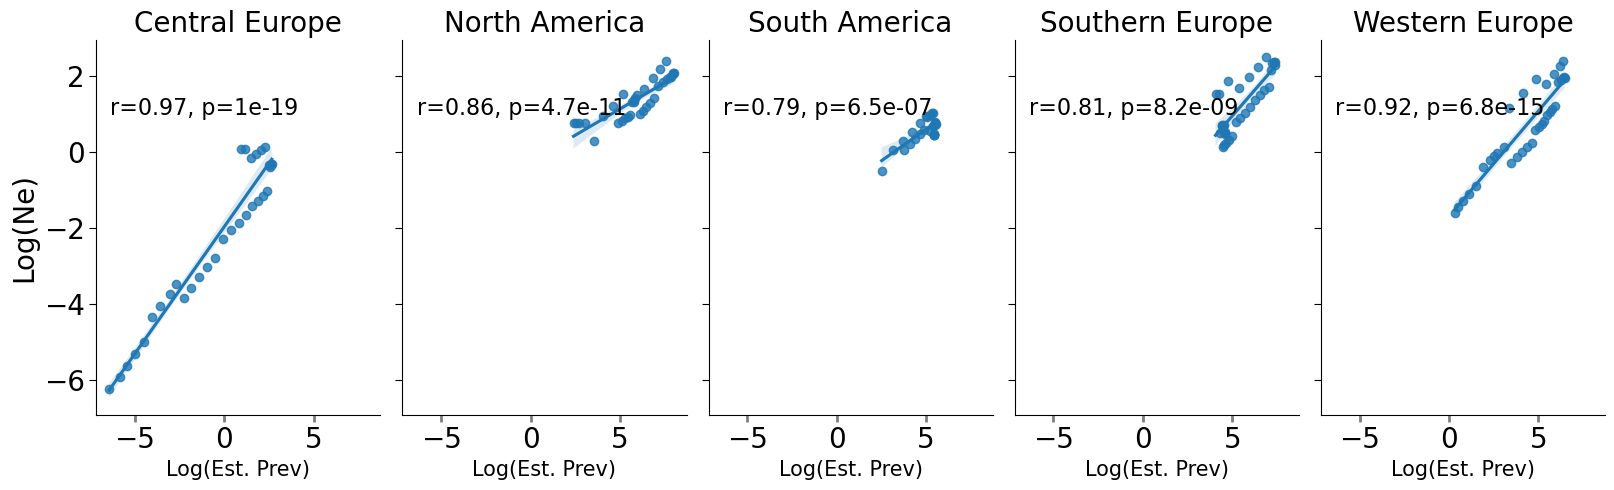

In [31]:

#tips = sns.load_dataset('tips')
g = sns.lmplot(x="log_median", y="mean_Ne_linear", data=combined_ne_prev_df,
               col='region', height=5, aspect=0.65)
g.set_titles(col_template="{col_name}", size = 20)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_median'], data['mean_Ne_linear'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, size = 16)
    ax.tick_params(axis='y',labelsize=20,size=5)
    ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
    ax.set_ylabel("Log(Ne)" , size=20)
    ax.set_xlabel("Log(Est. Prev)" , size=15)
    
g.map_dataframe(annotate)

plt.savefig('../figures/550_glm_region_ne_prev_corr.png',dpi=300,bbox_inches='tight')

plt.show()

/Users/mparedes/opt/miniconda3/envs/nextstrain/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


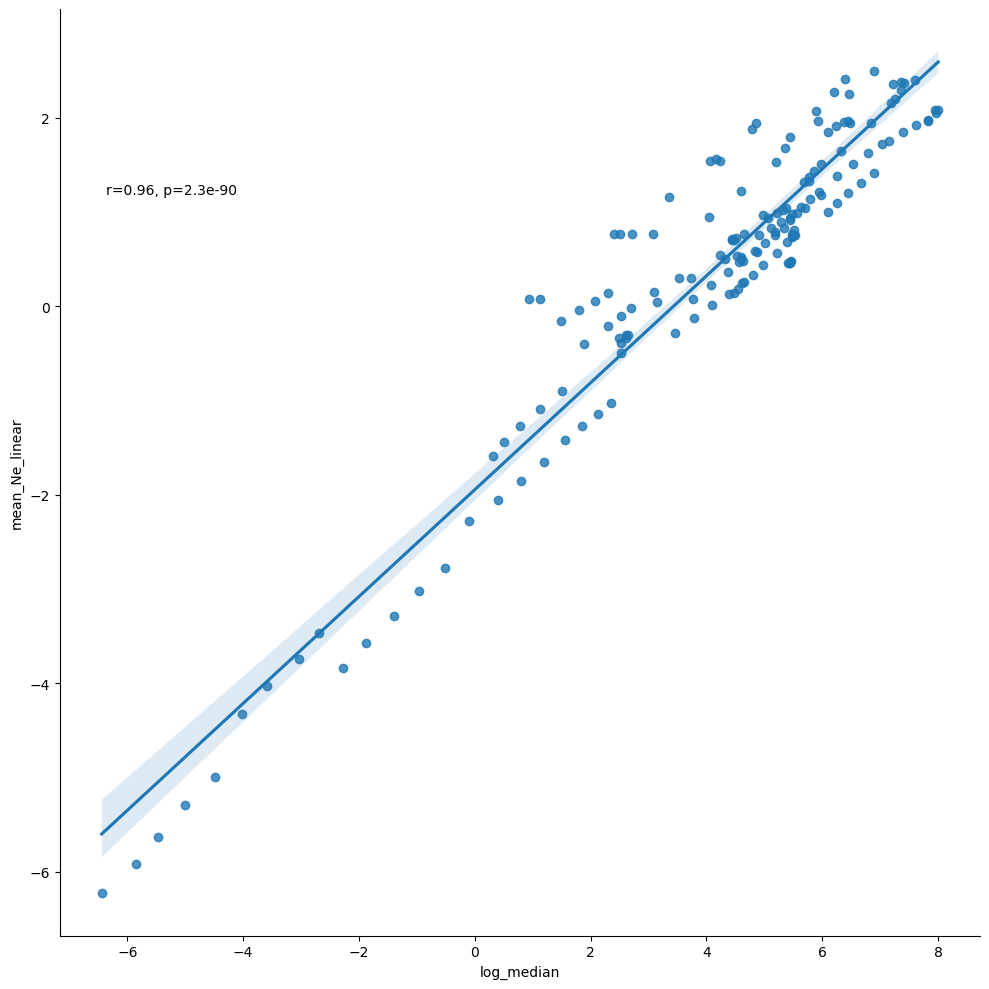

In [32]:
g = sns.lmplot(x="log_median", y="mean_Ne_linear", data=combined_ne_prev_df,
                height=10, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['log_median'], data['mean_Ne_linear'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

## plot regional tree reconstruction from mascot glm mcc tree

In [2]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [3]:
# set path to tree to load 
tree_path = "../mascot_glm/results/main/combined_mcc.tree"

In [5]:
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [6]:
all_geos = []

for k in tree.Objects: 
    if k.branchType=='node':
        #print(k.traits)
        division = k.traits['max']
        all_geos.append(division)
print(set(all_geos))

{'SouthernEurope', 'NorthAmerica', 'SouthAmerica', 'WesternEurope', 'CentralEurope'}


In [7]:
# add together probabilities for divisions in the same regions

# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []


for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['max']
        #region = regions[division]
        metadata[k] = {}
        metadata[k]["division"] = division
        #metadata[k]["region"] = region
        node_probs[k] = k.traits["max.prob"]  # for a leaf, this is always 1.0
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["max"]
        division_prob = k.traits["max.prob"]
        
        #node_region = regions[node_division]       
        geo_set = k.traits['max.set']
        geo_set_prob = k.traits['max.set.prob']
        
        node_prob = 0
        for i in range(len(geo_set)):
            division = geo_set[i]
            #region = regions[division]
            geo_prob = geo_set_prob[i]
            
            #if region == node_region:
            node_prob += geo_prob
        
        
        node_types[k] = {}
        node_types[k]["division"] = node_division
        #node_types[k]["region"] = node_region 
        node_probs[k] = division_prob
        pos_support.append(k.traits["posterior"])

        #division_probs[k] = division_prob
        #print(node_probs[k])

In [8]:
colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

uncertainty_color = "#B9B9B9"

division_order = [ 'CentralEurope','NorthAmerica','SouthAmerica', "SouthernEurope",  "WesternEurope"  ]

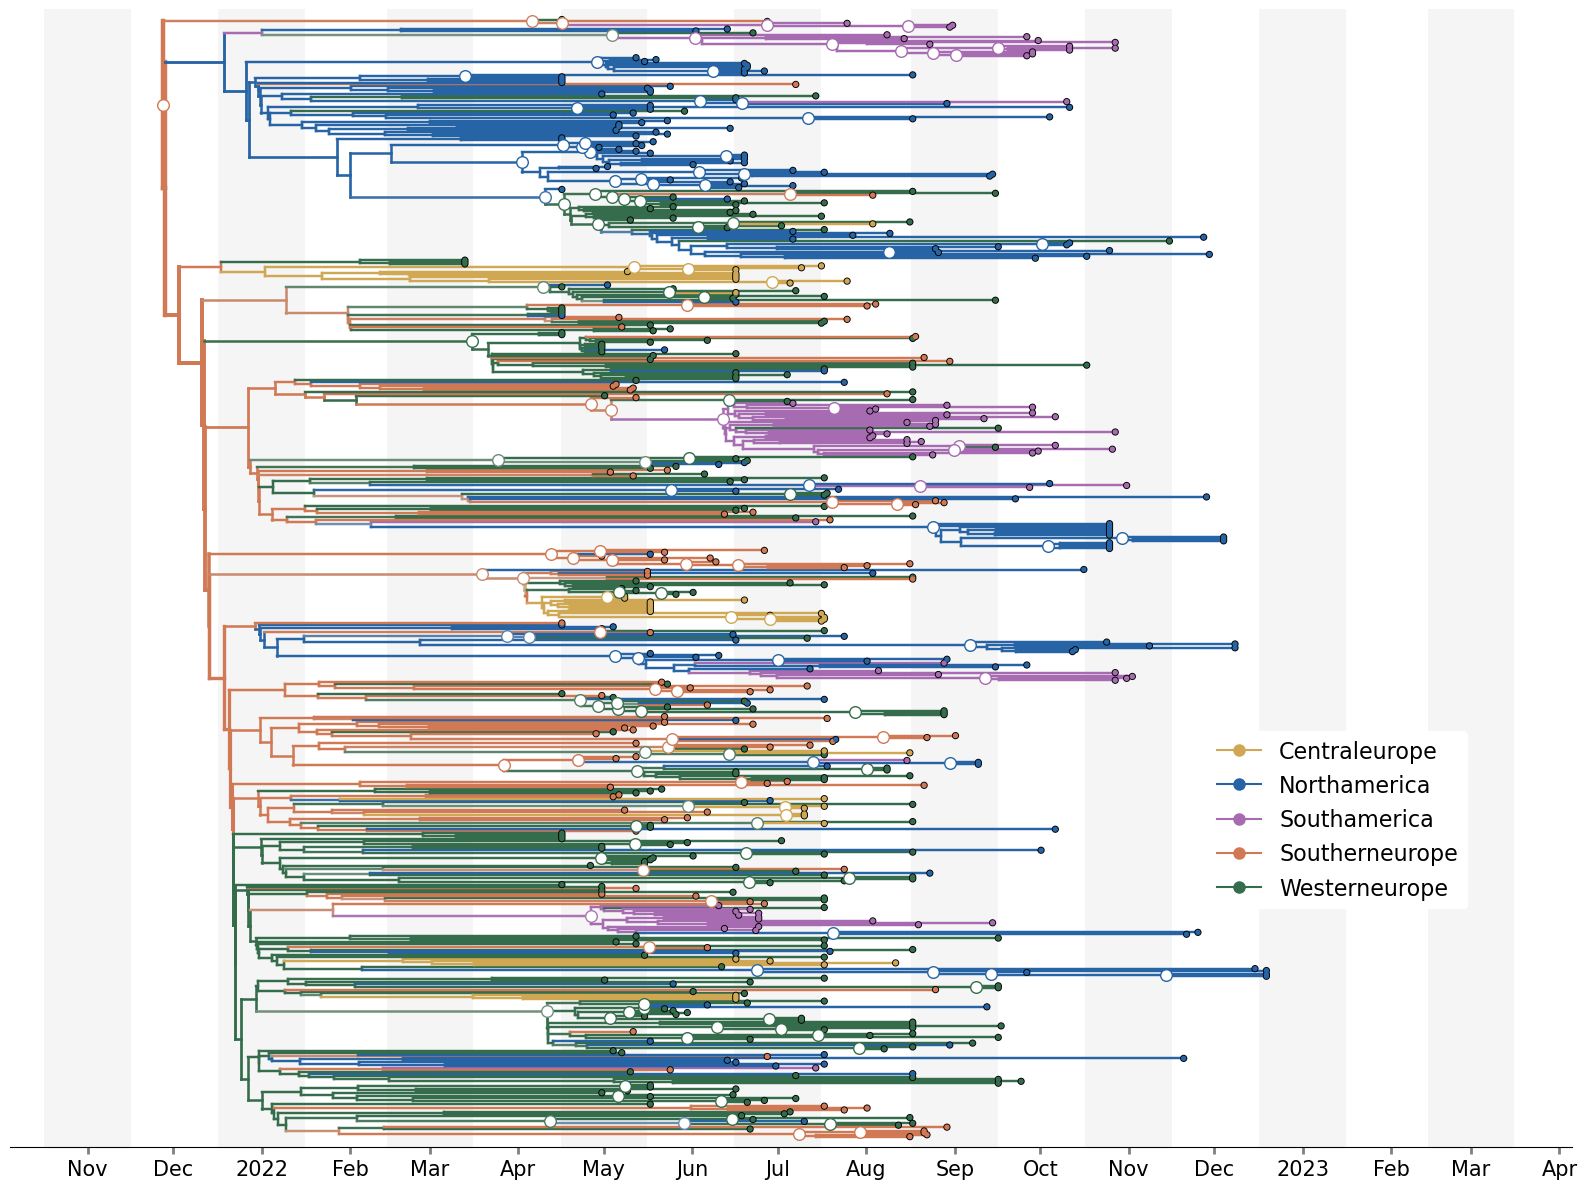

In [9]:
fig,ax = plt.subplots(figsize=(16,12),facecolor='w')



branchWidth=1.75 ## default branch width
tipSize = 15

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.set_xlim(2021.8,2023.3)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=15,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.76, 0.20], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
#plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_glm_region.png',dpi=300,bbox_inches='tight')

plt.show()

In [10]:
key_order = {"CentralEurope":1,
"NorthAmerica":2,
"SouthAmerica":3,
"SouthernEurope":4,
"WesternEurope":5,}

#division_order = [ 'NorthAmerica', "WesternEurope", 'CentralEurope', "SouthernEurope", 'SouthAmerica' ]

In [11]:
def enumerate_subtrees(tree):
    
    traitName="max"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [12]:
def plot_exploded_tree_no_cases(subtype_trees2, filename, width, height):
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    traitName='max'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=150


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["max.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            

               # if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
        
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                     else:
#                         ax1.plot([x,cutoff],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
       # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.2)
        

    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2021.8,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [18]:
subtype_trees2 = enumerate_subtrees(tree)


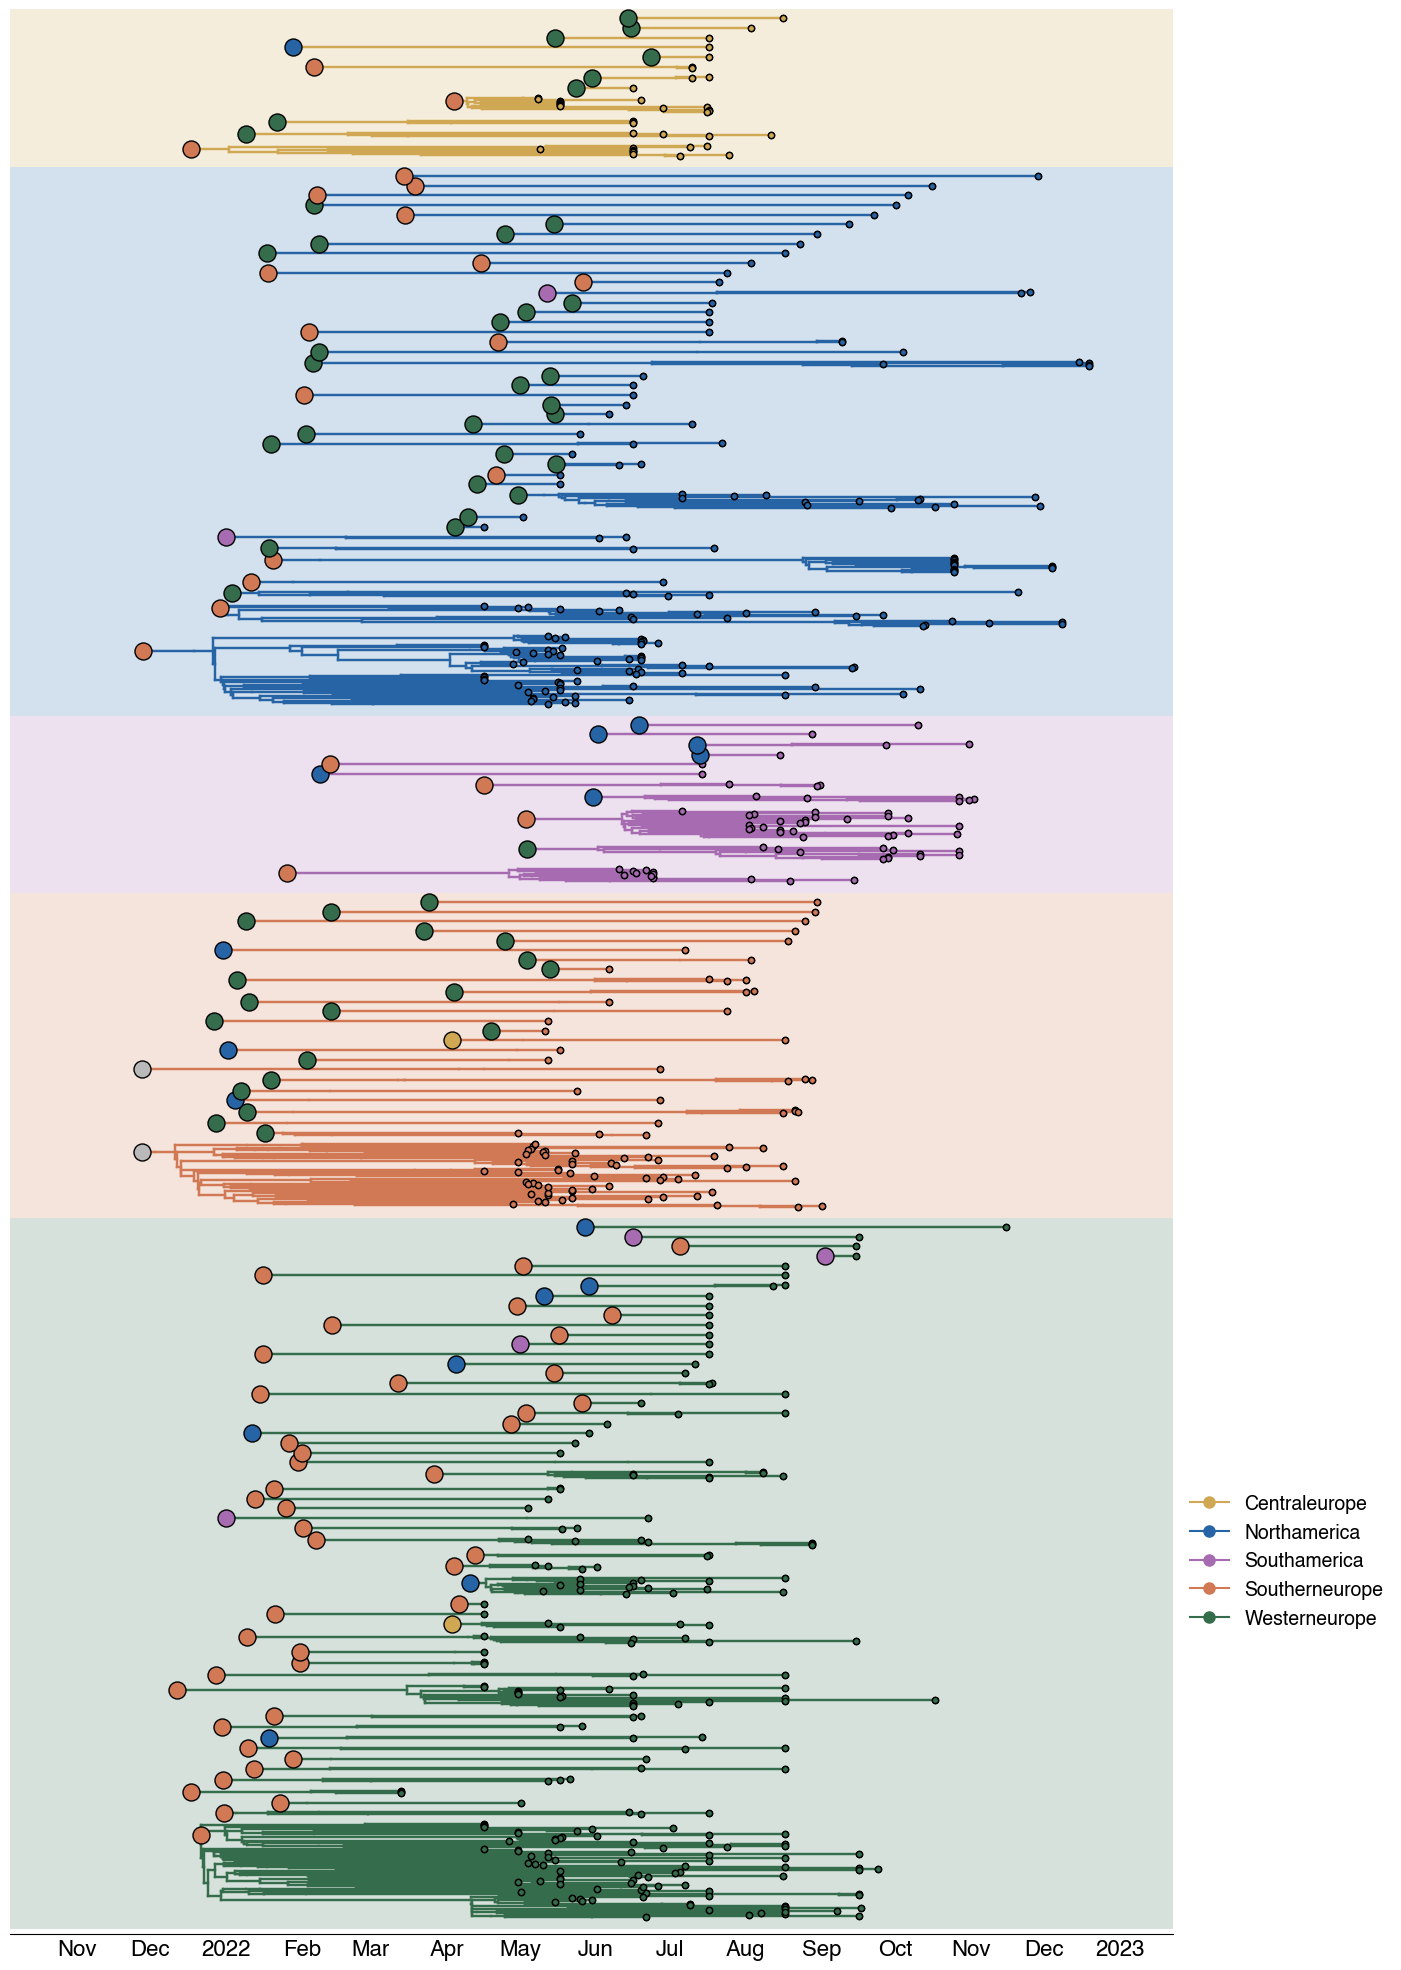

In [47]:

exploded_tree_output_file_name2 = "../figures/exploded_no_cases_region_glm.png"

plot_exploded_tree_no_cases(subtype_trees2, exploded_tree_output_file_name2,15,25)  # dotted lines, no case counts


In [51]:
region = {'Canada':'NorthAmerica',
          'USA':'NorthAmerica',
         'Finland':'NorthernEurope',
           'Austria': 'WesternEurope',
        'Germany':'WesternEurope', 
        'Switzerland':'WesternEurope',
         'United Kingdom':'WesternEurope',
        'France':'WesternEurope',
        'Belgium':'WesternEurope',
        'Netherlands':'WesternEurope',
        'Slovakia':'CentralEurope',
        'Slovenia':'CentralEurope',
        'Italy':'SouthernEurope',
        'Portugal':'SouthernEurope',
        'Spain':'SouthernEurope',
         'Colombia':'SouthAmerica',
          
        'Peru':'SouthAmerica'}

In [14]:
region_names = {'CentralEurope': 'Central Europe',
                'NorthAmerica': 'North America',
                'SouthAmerica': 'South America',
                'SouthernEurope': 'Southern Europe',
               'WesternEurope': 'Western Europe'}


In [15]:
region_names['NorthAmerica']

'North America'

In [55]:
def plot_exploded_tree_with_cases(subtype_trees2, filename, width, height, division_level):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    #print(raw_cases[raw_cases.location =="United Kingdom"])
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    #print(raw_cases.location.value_counts())
    raw_cases["region"] = np.nan
    raw_cases.region = raw_cases.location.map(region)
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    #print(raw_cases.location.value_counts())

    if division_level == "region":
        raw_cases = raw_cases.dropna()

        weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
    elif division_level =="country":
        weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
        
            
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='max'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=100
    cum_bar = 0


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["max.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    if k.traits['posterior']>=0.5:
                        ax1.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                ax1.scatter(oriX,oriY,s=origin_size*2,facecolor=oriC,edgecolor='w',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
            else:
                ax1.scatter(oriX,oriY,s=origin_size*0.5,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin


            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y))

    #overlay country cases    
    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        start = heights[i][0][0]
        end = heights[i][0][1]
        if division_level == "region":
            x = weekly_data.loc[weekly_data['region'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['region'] == i, "cases"]
        elif division_level =="country":
            x = weekly_data.loc[weekly_data['location'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['location'] == i, "cases"]        
        
        test = ((cases- (min(cases)))/(max(cases)-min(cases)))
        y1 = (((cases- (min(cases)))/(max(cases)-min(cases))) *(end- start))
        testprop= ((end-start)/cumulative_y)
        
        if division_level == "region":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)

        elif division_level =="country":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)

            #ax1.xaxis_date()
    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=22,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2021.8,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_63057/3177639970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_63057/3177639970.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


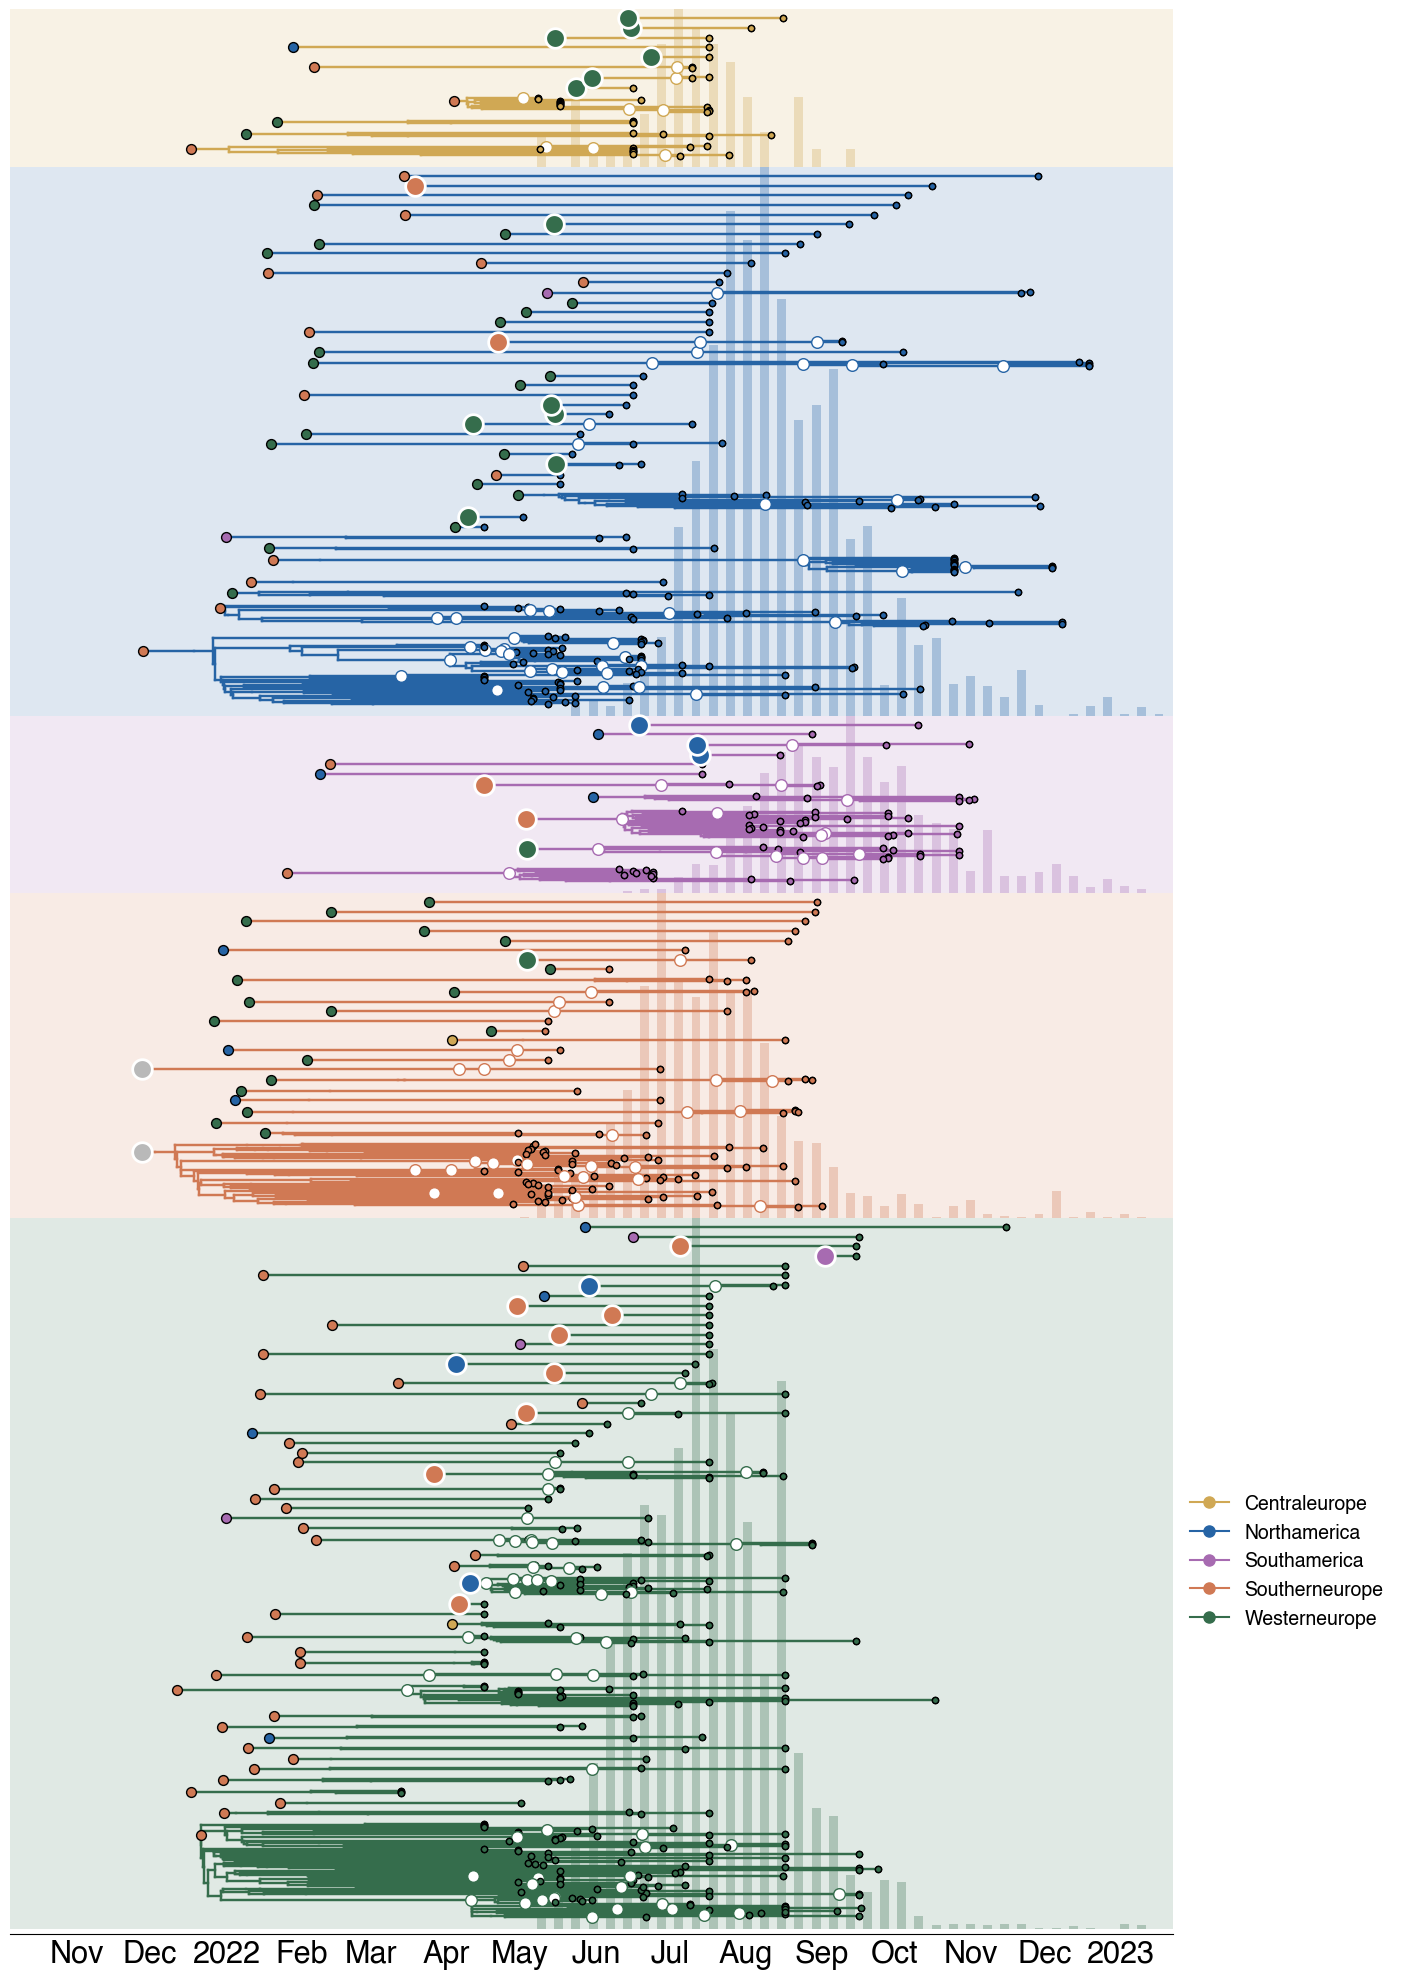

In [56]:
exploded_tree_output_file_name4 = "../figures/550_region_glm_cases_exploded_air.png"

plot_exploded_tree_with_cases(subtype_trees2, exploded_tree_output_file_name4,15,25, "region")  # dotted lines, no case counts


In [61]:
def plot_exploded_tree_with_cases_high_pos_prob(subtype_trees2, filename, width, height, division_level):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    #print(raw_cases[raw_cases.location =="United Kingdom"])
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    #print(raw_cases.location.value_counts())
    raw_cases["region"] = np.nan
    raw_cases.region = raw_cases.location.map(region)
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    #print(raw_cases.location.value_counts())

    if division_level == "region":
        raw_cases = raw_cases.dropna()

        weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
    elif division_level =="country":
        weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
        
            
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='max'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=25
    cum_bar = 0
    foo_cum_y = 0


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        #print(i)
        starting_y = cumulative_y
        cumulative_y+=10

        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            max_node_x = max(k.absoluteTime for k in loc_tree.Objects)

            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""

            # first, plot the origin circle
            oriC = colors[origin]
            

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                w = len(loc_tree.root.parent.leaves)
                radius=np.sqrt(w/np.pi)*200.0
                ax1.scatter(oriX,oriY,s=radius,facecolor=oriC,edgecolor='k',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
                loc_leaves=[w for w in loc_tree.Objects if w.branchType=='leaf']
                lastTip=max(k.absoluteTime for k in loc_tree.Objects)
                c = colors[loc_tree.root.traits[traitName]]
                originTime = loc_tree.root.parent.absoluteTime

                persistence=lastTip-originTime ## persistence is clade start - clade end (0 for tips)
                jitter=np.random.uniform(-0.4,0.4) ## jitter points vertically
                
               # ax1.scatter(np.mean([lastTip,originTime]),cumulative_y+jitter,s=radius,facecolor=c,edgecolor='k',zorder=10001,alpha=1.0) ## add clade size (area proportional to number of leaves in clade)

                ax1.plot([originTime,lastTip],[oriY,oriY],
                        lw=3,alpha=1.0,color=c,zorder=10000-w-1,solid_capstyle='round') ## add persistence line

                cumulative_y+=loc_tree.ySpan+8
        foo_cum_y+=loc_tree.ySpan+6
        oriC = colors[i]
        diff = cumulative_y - foo_cum_y
        ending_y = cumulative_y
        ax1.axhspan(ending_y,  starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y, diff))

    #overlay country cases    
    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        start = heights[i][0][0] 
        end = heights[i][0][1]
        diff_heights = heights[i][0][2]
        
        #print(i)
        if division_level == "region":
            x = weekly_data.loc[weekly_data['region'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['region'] == i, "cases"]
        elif division_level =="country":
            x = weekly_data.loc[weekly_data['location'] == i, "d_date"]
            cases = weekly_data.loc[weekly_data['location'] == i, "cases"]        
        #end = end- diff_heights
        test = ((cases- (min(cases)))/(max(cases)-min(cases)))
        y1 = (((cases- (min(cases)))/(max(cases)-min(cases))) *(end- start))
        testprop= ((end-start)/cumulative_y)
        
        if division_level == "region":
            ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)


            #ax1.xaxis_date()
    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2021.8,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_63057/410636096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_63057/410636096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


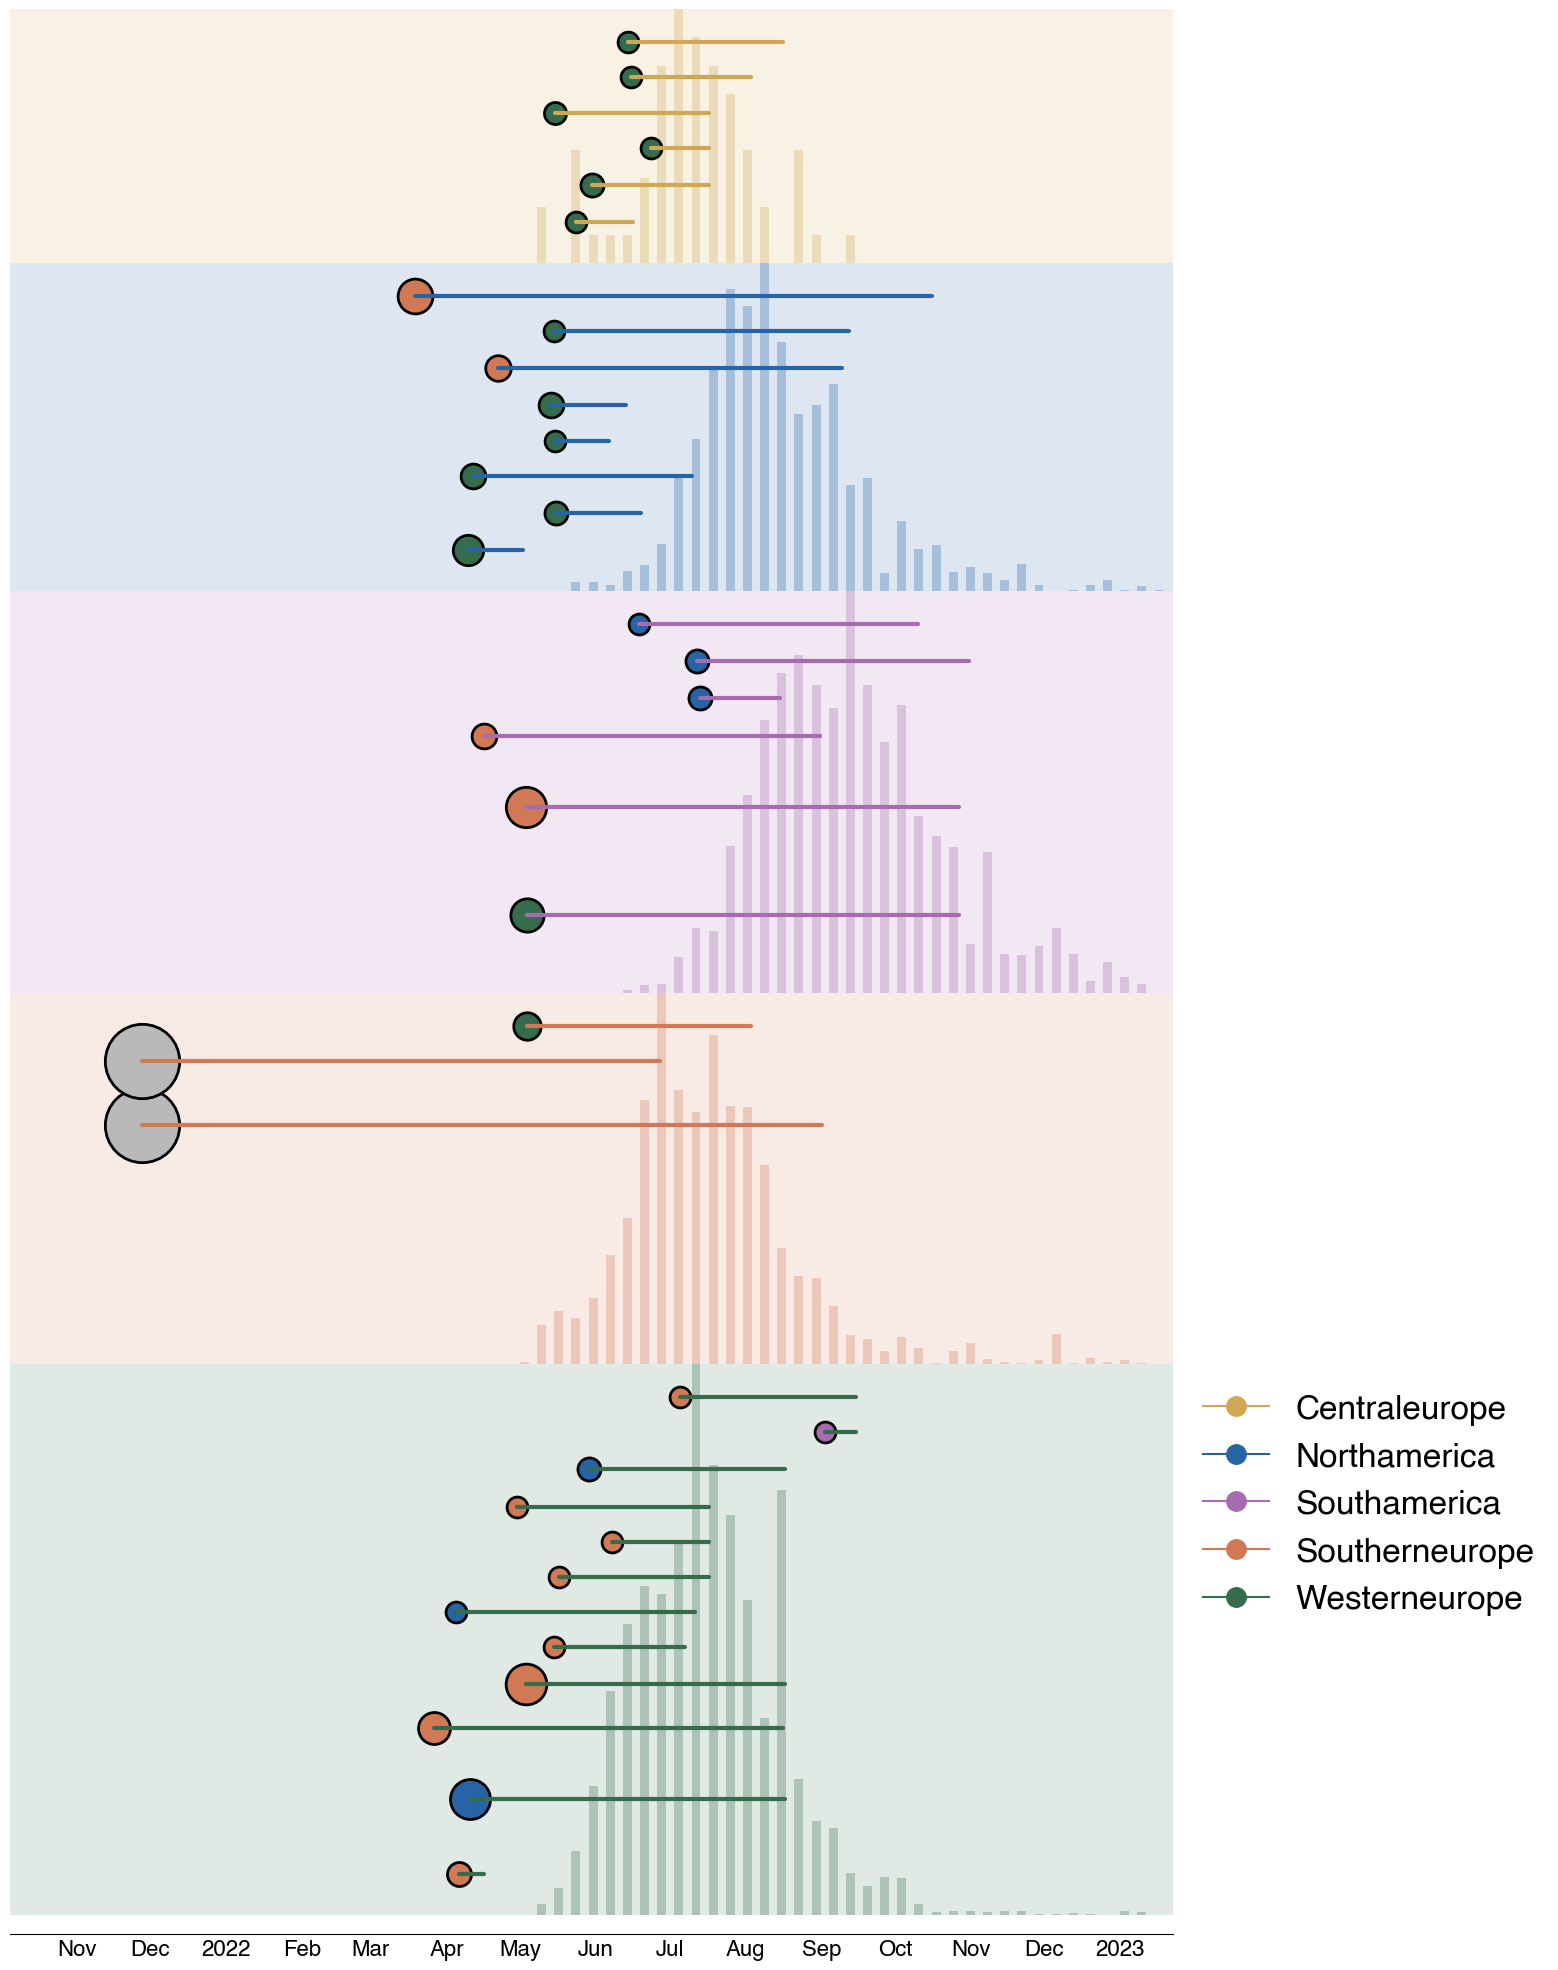

In [62]:
exploded_tree_output_file_name4 = "../figures/550_region_glm_cases_exploded_only_high_pos_supp.png"

plot_exploded_tree_with_cases_high_pos_prob(subtype_trees2, exploded_tree_output_file_name4,15,25, "region")  # dotted lines, no case counts


In [65]:
def decimal_to_days(decimal_value):
    days = int(decimal_value * 365)
    return days

In [68]:
def scatterplot_glm(subtype_trees2, filename, width, height, division_level):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    #print(raw_cases[raw_cases.location =="United Kingdom"])
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    #print(raw_cases.location.value_counts())
    raw_cases["region"] = np.nan
    raw_cases.region = raw_cases.location.map(region)
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    #print(raw_cases.location.value_counts())

    if division_level == "region":
        raw_cases = raw_cases.dropna()

        weekly_data = raw_cases.groupby("region").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["region","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
    elif division_level =="country":
        weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
        weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )
        
            
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='max'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=25
    cum_bar = 0
    foo_cum_y = 0
    per_list = []


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        #print(i)
        starting_y = cumulative_y
        cumulative_y+=10

        for subtree in subtype_trees2[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            max_node_x = max(k.absoluteTime for k in loc_tree.Objects)

            


            
            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""

            # first, plot the origin circle
            oriC = colors[loc_tree.root.traits['max']]
            #print(loc_tree.root.traits['max'])

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if (loc_tree.root.parent.traits['posterior']>=0.5):#& (origin != "ancestor"): # & (loc_tree.root.parent.absoluteTime < 2022.5822) :
                w = len(loc_tree.root.parent.leaves)
                radius=np.sqrt(w/np.pi)*200.0
                #ax1.scatter(oriX,oriY,s=radius,facecolor=oriC,edgecolor='k',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
                loc_leaves=[w for w in loc_tree.Objects if w.branchType=='leaf']
                lastTip=max(k.absoluteTime for k in loc_tree.Objects)
                c = colors[loc_tree.root.traits[traitName]]
                originTime = loc_tree.root.parent.absoluteTime

                persistence=lastTip-originTime ## persistence is clade start - clade end (0 for tips)
                persist_days = decimal_to_days(persistence)
                per_list.append([oriX,persist_days])
                #print(per_list)
                
                ax1.scatter(oriX,persist_days,s=radius,facecolor=oriC,edgecolor='k',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
                jitter=np.random.uniform(-0.4,0.4) ## jitter points vertically
                
               # ax1.scatter(np.mean([lastTip,originTime]),cumulative_y+jitter,s=radius,facecolor=c,edgecolor='k',zorder=10001,alpha=1.0) ## add clade size (area proportional to number of leaves in clade)

                #ax1.plot([originTime,lastTip],[oriY,oriY],
                #        lw=3,alpha=1.0,color=c,zorder=10000-w-1,solid_capstyle='round') ## add persistence line

                cumulative_y+=loc_tree.ySpan+8
        foo_cum_y+=loc_tree.ySpan+6
        oriC = colors[i]
        diff = cumulative_y - foo_cum_y
        ending_y = cumulative_y
       # ax1.axhspan(ending_y,  starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y, diff))

    per_df = pd.DataFrame(per_list, columns = ["date", "persistence"])
    corr, _ = pearsonr(per_df.date, per_df.persistence)
    r, p = sp.stats.pearsonr(per_df.date, per_df.persistence)
    #ax = plt.gca()
    ax1.text(.2, .75, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax1.transAxes)
    sns.regplot(x="date", y="persistence", data = per_df, scatter=False, ax=ax1, color='steelblue', line_kws={'linestyle': '--', 'linewidth': 1}, label='Pearson Correlation: {corr:.2f}')


    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = region_names[key], markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[.50, 0.75], loc=3, prop={'size': 18}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2021,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right']]

    ax1.tick_params(axis='y',size=0)
#    ax1.set_yticklabels([])
    ax1.set_ylim(0,(max(per_df.persistence)+25))
    ax1.set_xlim(2021.8,2023)
    ax1.set_ylabel("Persistence times (days)", fontsize=20, fontweight='bold')
    ax1.set_xlabel("", fontsize=25, fontweight='bold')



    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_63057/1130108750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_63057/1130108750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


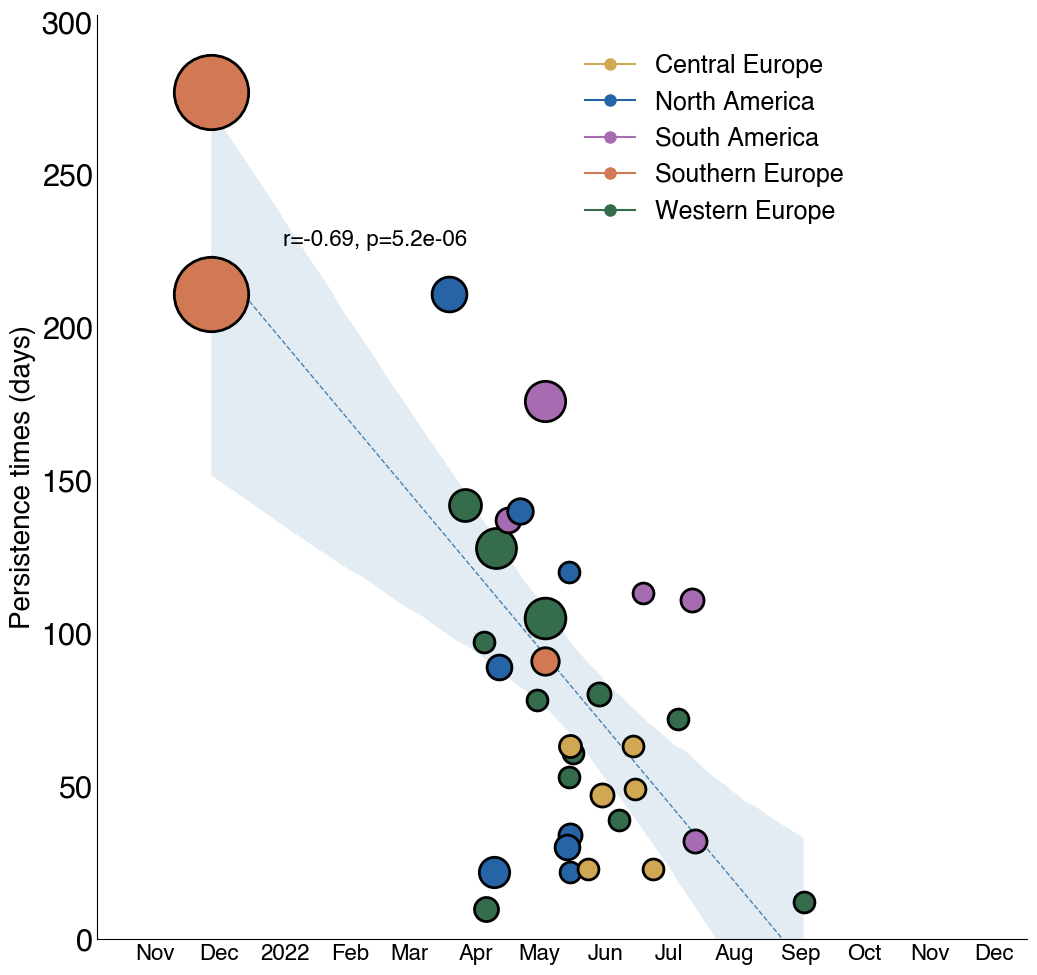

In [70]:
exploded_tree_output_file_name4 = "../figures/550_region_glm_scatter.png"

scatterplot_glm(subtype_trees2, exploded_tree_output_file_name4,12,12, "region")  # dotted lines, no case counts


In [ ]:
## plotting coefficient estimates for MASCOT-GLM predictors

In [48]:
month = {'month_predictor_0':'April 2022',
          'month_predictor_1':'May 2022',
         'month_predictor_2':'June 2022',
           'month_predictor_3': 'July 2022',
        'month_predictor_4':'August 2022', 
        'month_predictor_5':'September 2022',
         'month_predictor_6':'October 2022',
        'month_predictor_7':'November 2022',
        'month_predictor_8':'Decemeber 2022',
        'month_predictor_9':'Janaury 2023',
         'region_cases_weekly':'Weekly Cases',
         'region_cases_weekly_prevalence':'Weekly Prevalence',
         '_region_300Clock':'Clock', 
         "regions_air_travel_matrix":"Air Passenger Volumes"
}

In [49]:
def read_in_Ne_changes_mascot(log_file_path):  
    
    Ne_skyline_dict = {"sample":[]}

    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if ("NeGLM."  in col) or ("migrationGLM." in col):
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "Ne.region.1" where region is deme and 1 is interval 1
                        #interval = name.split(".")[2]

                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])

    return(Ne_skyline_dict)

In [50]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        print(i)
        if ("NeGLM."in i) or ("migrationGLM" in i):
            if "Clock" in i: 
                deme = i.split(".")[1]
            else:
                deme = i.split(".")[2]
            local_series = input_df[i].astype('float').to_numpy()
            mean_log = local_series.mean()
            median_log = np.median(local_series)
            mean_linear = 10**mean_log
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = 10**lower_hpd_log_95
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = 10**upper_hpd_log_95
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = 10**lower_hpd_log_50
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = 10**upper_hpd_log_50
            
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "median_Ne_log" : median_log, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95})
                new_df = new_df.append(local_df)
                #print(new_df)
            except:
                pass
            
    return(new_df)

In [51]:
log_file_path = "../mascot_glm/results/main/combined_exp_glm.log"


In [52]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
ne_summary = generate_summary_df(Ne_df)

sample
migrationGLM._region_300Clock
migrationGLM._region_300scaler.regions_air_travel_matrix
NeGLM._region_300Clock
NeGLM._region_300scaler.region_cases_weekly_prevalence
NeGLM._region_300scaler.month_predictor_0
NeGLM._region_300scaler.month_predictor_1
NeGLM._region_300scaler.month_predictor_2
NeGLM._region_300scaler.month_predictor_3
NeGLM._region_300scaler.month_predictor_4
NeGLM._region_300scaler.month_predictor_5
NeGLM._region_300scaler.month_predictor_6
NeGLM._region_300scaler.month_predictor_7
NeGLM._region_300scaler.month_predictor_8
NeGLM._region_300scaler.month_predictor_9


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/591882125.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/591882125.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/591882125.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99772/591882125.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [53]:
ne_summary["predictor"] = ne_summary.deme.map(month)
ne_pred = ne_summary.iloc[2:]
mig_pred = ne_summary.iloc[1:2]

In [54]:
#ne predictors

points = alt.Chart(ne_pred).mark_point(filled=True, color='black', width = 5).encode(
  y=alt.Y('mean_Ne_log:Q',axis = alt.Axis(title = "Coefficient", grid =False, labelFontSize= 24,titleFontSize= 24) ),
  x=alt.X('predictor', title = "Predictor", sort= list(month.values()),  axis=alt.Axis(labelFontSize= 24,titleFontSize= 24,labelLimit = 0, labelAngle=-35)),
).transform_filter(datum.predictor != "Clock" or datum.predictor != "air").properties(
    width=850,
    height=300
)

hpd = alt.Chart(ne_pred).mark_rule(strokeWidth = 2).encode(
    y2=alt.Y2("upper_hpd_log_95"),
    y = alt.Y("lower_hpd_log_95"),
    x=alt.X("predictor",sort =  list(month.values()))
).transform_filter(datum.predictor != "Clock").properties(
    width=850,
    height=300
)

one_line = alt.Chart(pd.DataFrame({'y': [0.0]})).mark_rule(strokeDash=[1,1]).encode(y='y').properties(
    width=850,
    height=300
)

predict_coeff = (points + hpd + one_line).properties(title='D')
predict_coeff.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 35
).configure_axis(
    labelFontSize=60,
    titleFontSize=60
).configure_legend(
    labelFontSize = 60)

alt.LayerChart(...)

In [55]:
#migration predictors
points = alt.Chart(mig_pred).mark_point(filled=True, color='black').encode(
  y=alt.Y('mean_Ne_log:Q',axis = alt.Axis(title = "Coefficient", grid =False, labelFontSize= 18,titleFontSize= 16) ),
  x=alt.X('predictor', title = "Predictor",  axis=alt.Axis(labelFontSize= 16,titleFontSize= 16, labelAngle=-35)),
).transform_filter(datum.predictor != "Clock" ).properties(
    width=200,
    height=200
)

hpd = alt.Chart(mig_pred).mark_rule().encode(
    y2=alt.Y2("upper_hpd_log_95"),
    y = alt.Y("lower_hpd_log_95"),
    x=alt.X("predictor")
).transform_filter(datum.predictor != "Clock").properties(
    width=300,
    height=150
)

one_line = alt.Chart(pd.DataFrame({'y': [0.0]})).mark_rule(strokeDash=[1,1]).encode(y='y').properties(
    width=300,
    height=150
)

predict_coeff = (points + hpd ).properties(title='B')
predict_coeff.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 25
).configure_axis(
    labelFontSize=24,
    titleFontSize=24
).configure_legend(
    labelFontSize = 60)


alt.LayerChart(...)